In [1]:
!pip install imageio

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [1]:
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchsummary import summary
from utils import TrainTest, PlotOutput
from tqdm import tqdm

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from models.resnet import ResNet18

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# augmentations
# x = datasets.CIFAR10(root='./data', train=True, download=True)

mean = [0.49139968, 0.48215841, 0.44653091] # (x.data.transpose() / 255).reshape(3,-1).mean(-1)
std = [0.24703223, 0.24348513, 0.26158784] # (x.data.transpose() / 255).reshape(3,-1).std(-1)

train_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        A.ToGray(p=0.2),
        A.PadIfNeeded(40, 40, p=1),
        A.RandomCrop(32, 32, p=1),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, fill_value=0, p=1),
        A.Resize(32, 32),
        ToTensorV2()
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ]
)

In [4]:
from PIL import Image

class ACIFAR10(datasets.CIFAR10):
    def __init__(self, mean, std, **kwargs):
        super(ACIFAR10, self).__init__(**kwargs)
        self.mean = torch.tensor(mean).reshape(len(mean), 1, 1)
        self.std = torch.tensor(std).reshape(len(std), 1, 1)
    
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        
        if self.transform is not None:
            img = self.transform(image=img)["image"]
        
        return img, target

In [5]:
# datasets
trainset = ACIFAR10(
    mean=mean, std=std, root='./data', train=True, download=True, transform=train_transform)

testset = ACIFAR10(
    mean=mean, std=std, root='./data', train=False, download=True, transform=test_transform)

# dataloaders
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


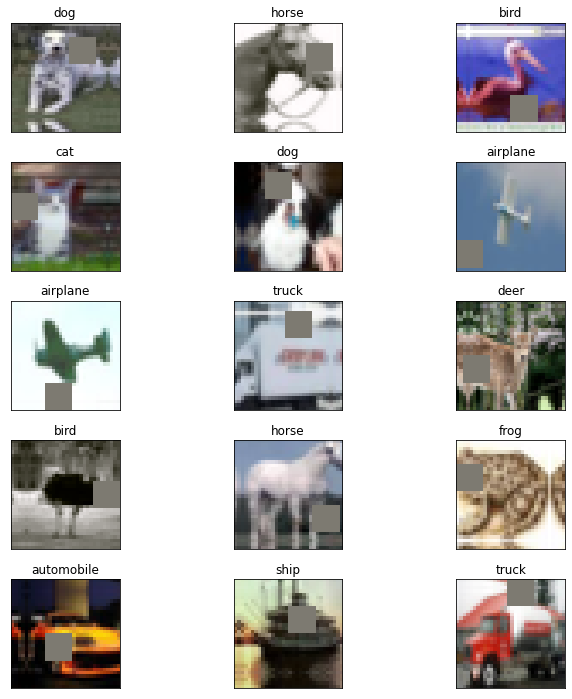

In [6]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(10, 10))
batch_data, batch_label = next(iter(train_loader))

t_std = train_loader.dataset.std
t_mean = train_loader.dataset.mean


for i in range(15):
    plt.subplot(5, 3, i+1)
    plt.tight_layout()

    # get an image - [3, 32, 32]
    # and denormalize
    image = batch_data[i] * t_std + t_mean

    # Clip the input data to the valid range [0, 1]
    image = image.clip(0, 1)
    
    # [3, 32, 32] to [32, 32, 3]
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    
    plt.title(classes[batch_label[i].item()])
    plt.xticks([])
    plt.yticks([])

In [7]:
model = ResNet18(dropout=0.).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [8]:
criterion = F.cross_entropy
optimizer = optim.Adam(model.parameters(), lr=0.01)

/home/qblocks/.local/lib/python3.8/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.32E-02


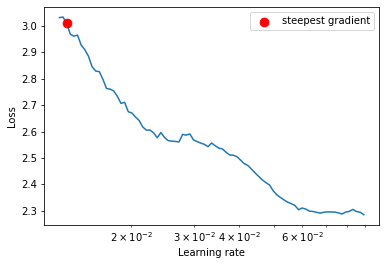

In [9]:
from torch_lr_finder import LRFinder

EPOCHS = 25

def find_lr():
    lr_finder = LRFinder(model, optimizer, criterion, device=device)
    lr_finder.range_test(train_loader, end_lr=0.1, num_iter=100, step_mode='exp')

    _, best_lr = lr_finder.plot()
    lr_finder.reset()
    
    return best_lr 


scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=find_lr(),
            steps_per_epoch=len(train_loader),
            epochs=EPOCHS,
            pct_start=5 / EPOCHS,
            div_factor=100,
            three_phase=False,
            final_div_factor=100,
            anneal_strategy='linear'
        )

In [10]:
target_layers = [model.layer4[-1], model.layer3[-1], model.layer2[-1]]

run = TrainTest(model=model, 
                trainloader=train_loader, 
                testloader=test_loader, 
                optimizer=optimizer, 
                criterion=criterion, 
                scheduler=scheduler,
                target_layers=target_layers)

image_idx = [15, 25, 446, 416, 96]

run(epochs=EPOCHS, cam=True, image_idx=image_idx)
run.save_grad_cam_gif(image_idx=image_idx, output_directory="./cam_output/")

Train: Loss=1.5456 Batch_id=1562 Accuracy=43.65: 100%|██████████| 1563/1563 [00:38<00:00, 41.10it/s]


Test set: Average loss: 1.4111, Accuracy: 5276/10000 (52.76%)



Train: Loss=1.1210 Batch_id=1562 Accuracy=60.64: 100%|██████████| 1563/1563 [01:02<00:00, 25.20it/s]


Test set: Average loss: 0.9911, Accuracy: 6638/10000 (66.38%)



Train: Loss=0.9343 Batch_id=1562 Accuracy=67.63: 100%|██████████| 1563/1563 [01:15<00:00, 20.76it/s]


Test set: Average loss: 0.8902, Accuracy: 7063/10000 (70.63%)



Train: Loss=0.8472 Batch_id=1562 Accuracy=70.77: 100%|██████████| 1563/1563 [01:15<00:00, 20.72it/s]


Test set: Average loss: 0.6955, Accuracy: 7595/10000 (75.95%)



Train: Loss=0.7760 Batch_id=1562 Accuracy=73.10: 100%|██████████| 1563/1563 [01:15<00:00, 20.66it/s]


Test set: Average loss: 0.6744, Accuracy: 7731/10000 (77.31%)



Train: Loss=0.7125 Batch_id=1562 Accuracy=75.35: 100%|██████████| 1563/1563 [01:16<00:00, 20.47it/s]


Test set: Average loss: 0.6404, Accuracy: 7847/10000 (78.47%)



Train: Loss=0.6370 Batch_id=1562 Accuracy=78.02: 100%|██████████| 1563/1563 [01:16<00:00, 20.36it/s]


Test set: Average loss: 0.5524, Accuracy: 8133/10000 (81.33%)



Train: Loss=0.5772 Batch_id=1562 Accuracy=80.04: 100%|██████████| 1563/1563 [01:16<00:00, 20.31it/s]


Test set: Average loss: 0.4620, Accuracy: 8440/10000 (84.40%)



Train: Loss=0.5306 Batch_id=1562 Accuracy=81.73: 100%|██████████| 1563/1563 [01:17<00:00, 20.27it/s]


Test set: Average loss: 0.4327, Accuracy: 8525/10000 (85.25%)



Train: Loss=0.4878 Batch_id=1562 Accuracy=83.23: 100%|██████████| 1563/1563 [01:16<00:00, 20.41it/s]


Test set: Average loss: 0.4228, Accuracy: 8513/10000 (85.13%)



Train: Loss=0.4487 Batch_id=1562 Accuracy=84.44: 100%|██████████| 1563/1563 [01:18<00:00, 19.95it/s]


Test set: Average loss: 0.3752, Accuracy: 8753/10000 (87.53%)



Train: Loss=0.4168 Batch_id=1562 Accuracy=85.61: 100%|██████████| 1563/1563 [01:17<00:00, 20.13it/s]


Test set: Average loss: 0.3470, Accuracy: 8845/10000 (88.45%)



Train: Loss=0.3828 Batch_id=1562 Accuracy=86.70: 100%|██████████| 1563/1563 [01:15<00:00, 20.62it/s]


Test set: Average loss: 0.3312, Accuracy: 8851/10000 (88.51%)



Train: Loss=0.3590 Batch_id=1562 Accuracy=87.69: 100%|██████████| 1563/1563 [01:16<00:00, 20.38it/s]


Test set: Average loss: 0.3125, Accuracy: 8947/10000 (89.47%)



Train: Loss=0.3350 Batch_id=1562 Accuracy=88.46: 100%|██████████| 1563/1563 [01:17<00:00, 20.13it/s]


Test set: Average loss: 0.3056, Accuracy: 8990/10000 (89.90%)



Train: Loss=0.3051 Batch_id=1562 Accuracy=89.34: 100%|██████████| 1563/1563 [01:16<00:00, 20.52it/s]


Test set: Average loss: 0.2868, Accuracy: 9022/10000 (90.22%)



Train: Loss=0.2813 Batch_id=1562 Accuracy=90.27: 100%|██████████| 1563/1563 [01:17<00:00, 20.20it/s]


Test set: Average loss: 0.2911, Accuracy: 9018/10000 (90.18%)



Train: Loss=0.2638 Batch_id=1562 Accuracy=90.76: 100%|██████████| 1563/1563 [01:15<00:00, 20.66it/s]


Test set: Average loss: 0.2676, Accuracy: 9137/10000 (91.37%)



Train: Loss=0.2431 Batch_id=1562 Accuracy=91.63: 100%|██████████| 1563/1563 [01:16<00:00, 20.34it/s]


Test set: Average loss: 0.2567, Accuracy: 9169/10000 (91.69%)



Train: Loss=0.2235 Batch_id=1562 Accuracy=92.15: 100%|██████████| 1563/1563 [01:17<00:00, 20.26it/s]


Test set: Average loss: 0.2469, Accuracy: 9178/10000 (91.78%)



Train: Loss=0.2028 Batch_id=1562 Accuracy=92.98: 100%|██████████| 1563/1563 [01:15<00:00, 20.68it/s]


Test set: Average loss: 0.2317, Accuracy: 9256/10000 (92.56%)



Train: Loss=0.1893 Batch_id=1562 Accuracy=93.35: 100%|██████████| 1563/1563 [01:18<00:00, 19.82it/s]


Test set: Average loss: 0.2366, Accuracy: 9224/10000 (92.24%)



Train: Loss=0.1729 Batch_id=1562 Accuracy=93.93: 100%|██████████| 1563/1563 [01:17<00:00, 20.15it/s]


Test set: Average loss: 0.2285, Accuracy: 9279/10000 (92.79%)



Train: Loss=0.1574 Batch_id=1562 Accuracy=94.45: 100%|██████████| 1563/1563 [01:16<00:00, 20.48it/s]


Test set: Average loss: 0.2198, Accuracy: 9309/10000 (93.09%)



Train: Loss=0.1480 Batch_id=1562 Accuracy=94.85: 100%|██████████| 1563/1563 [01:14<00:00, 21.05it/s]


Test set: Average loss: 0.2185, Accuracy: 9311/10000 (93.11%)



In [11]:
plot = PlotOutput(model, target_layers=target_layers, device=device)

100%|██████████| 313/313 [00:10<00:00, 31.01it/s]


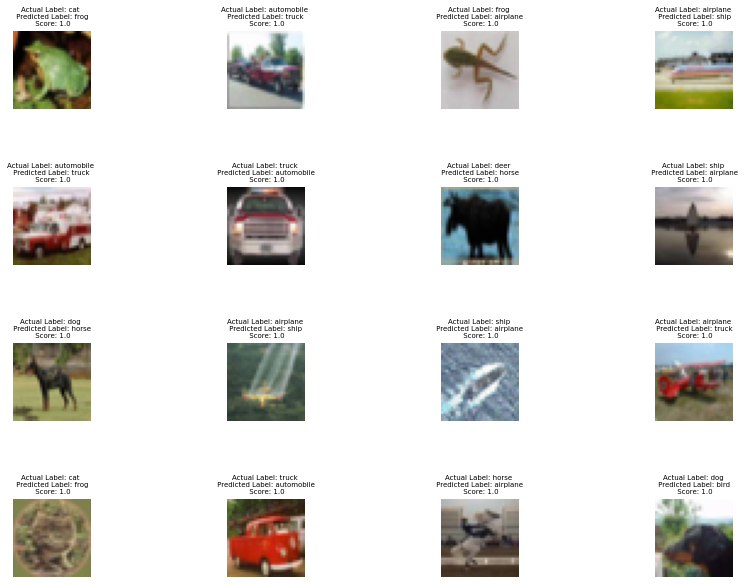

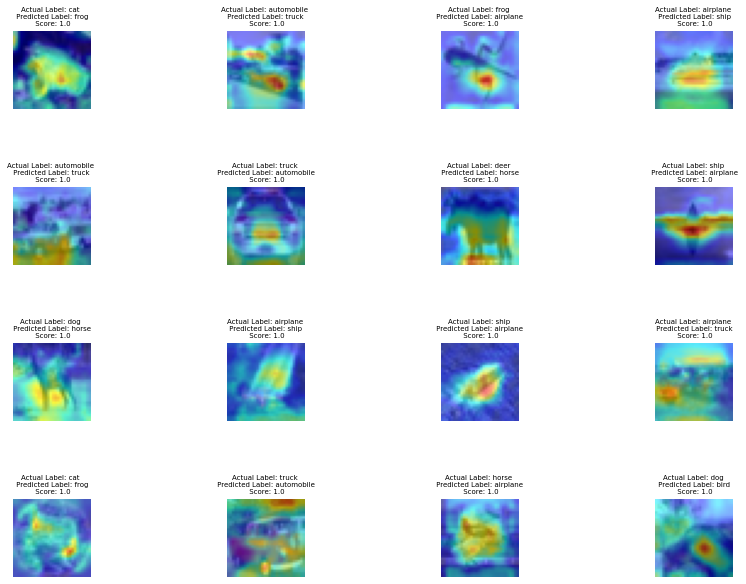

In [15]:
plot.run_prediction(test_loader, ptype="incorrect")

plot.plot(n=16, class_list=classes, grad_cam=False)
plot.plot(n=16, class_list=classes, grad_cam=True)

100%|██████████| 313/313 [00:10<00:00, 30.42it/s]


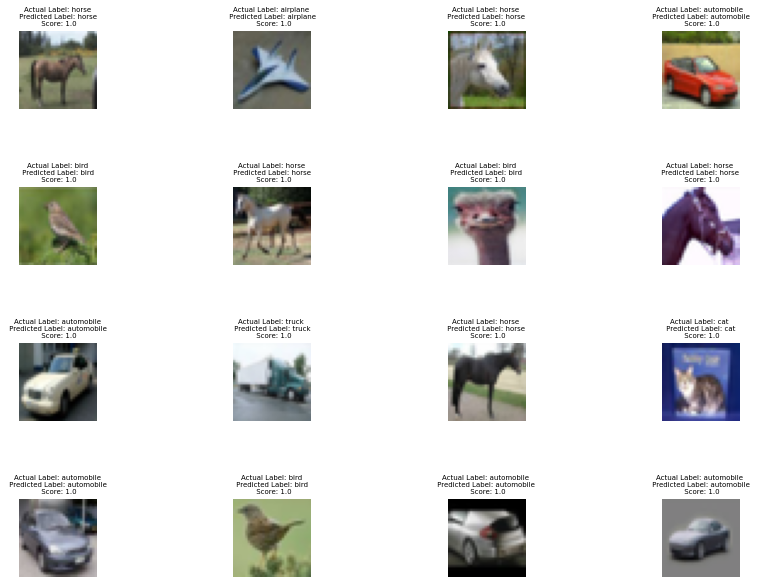

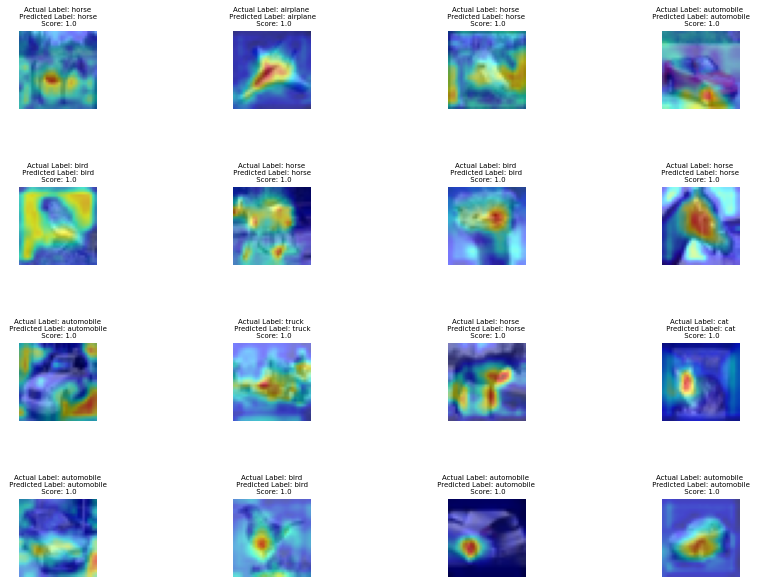

In [13]:
plot.run_prediction(test_loader, ptype="correct")

plot.plot(n=16, class_list=classes, grad_cam=False, reverse=True)
plot.plot(n=16, class_list=classes, grad_cam=True, reverse=True)

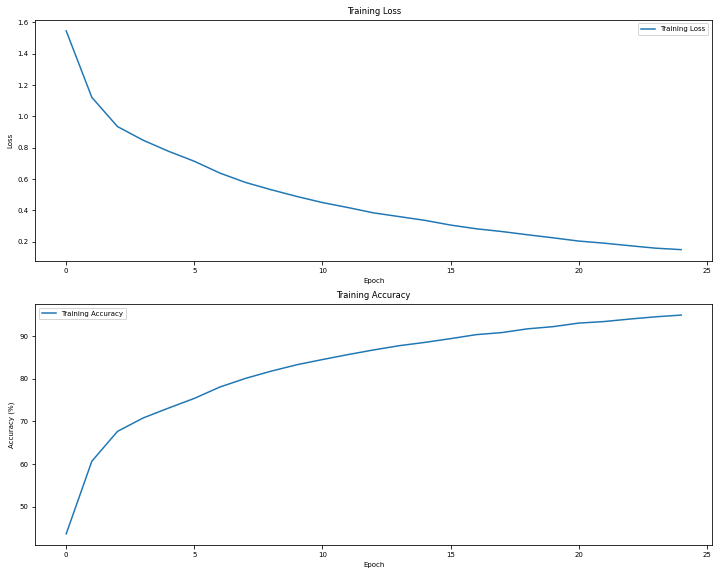

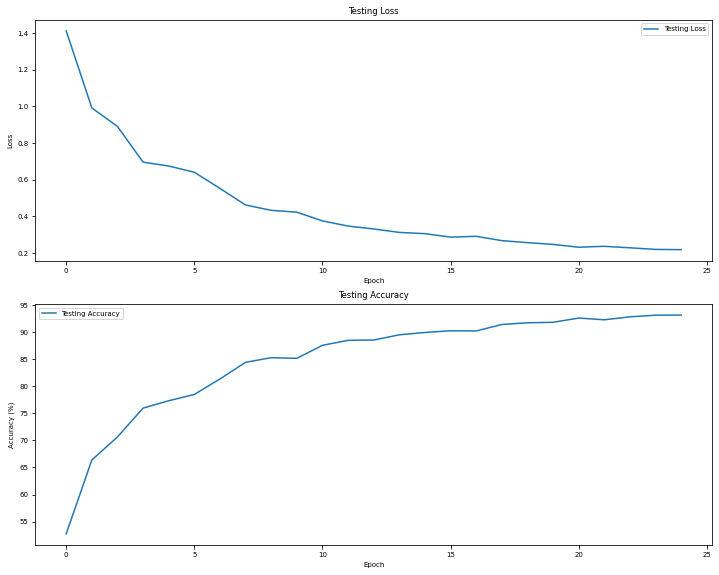

In [14]:
run.train.plot_stats()
run.test.plot_stats()